# TC Profiling: Service Performance Model



In [6]:
# global settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata
import numpy as np
import seaborn
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import networkx as nx
import itertools as it

In [7]:
def cartesian_product(p_dict):
    """
    Compute Cartesian product on parameter dict:
    In:
        {"number": [1,2,3], "color": ["orange","blue"] }
    Out:
        [ {"number": 1, "color": "orange"},
          {"number": 1, "color": "blue"},
          {"number": 2, "color": "orange"},
          {"number": 2, "color": "blue"},
          {"number": 3, "color": "orange"},
          {"number": 3, "color": "blue"}
        ]
    """
    p_names = sorted(p_dict)
    return [dict(zip(p_names, prod)) for prod in it.product(
        *(p_dict[n] for n in p_names))]

In [8]:
def draw_graph(G):
    pos=nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, font_size=7)
    edge_labels = nx.get_edge_attributes(G,'capacity')
    nx.draw_networkx_edge_labels(G, pos, labels = edge_labels, font_size=7)
    plt.show()



## Model Design

### Assumptions

- Focus on throughput only.

### VNFs

Each VNF with a function that maps $m$ configuration parameters of the VNF to its performance, i.e., $(p_1, p_2, ... p_m) \rightarrow r$


### Service

SFC is modeled as an arbitrary directed graph with a service ingress point ($s$) and a service egress point ($t$). Each node in the graph is a VNF: $s \rightarrow f_1  \rightarrow  f_2  \rightarrow  ...  \rightarrow f_n  \rightarrow t$. To calculate the overall performance of the SFC, a function is assigned to this graph wich maps a set of $n$ configurations (on for each VNF of the SFC) to the overall performance, i.e., $((p_1, p_2, ... p_m)_1, (p_1, p_2, ... p_m)_2, ... (p_1, p_2, ... p_m)_n) \rightarrow R$. In our case, which focuses on the maximum throughput of the SFC, the performance of each VNF is calculated using its given configuration which results in a graph with throughput capacities assigned to its nodes. Having this, we can easily calculate the overall throughput of the SFC by using solving the \emph{maximum flow} problem between $s$ and $t$.

### Setup

* Parameter set with $m$ parameters
* $n$ VNFs
* Service graph (DAG)

### Evaluation


* Input: $C = 
\begin{pmatrix}
  p_{1,1} & p_{1,2} & \cdots & p_{1,m} \\
  p_{2,1} & p_{2,2} & \cdots & p_{2,m} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  p_{n,1} & p_{n,2} & \cdots & p_{n,m} 
 \end{pmatrix}
$


* Mapping: `evaluate(`$C$ `)`$\rightarrow R$

* Output: $R$ is a single throughput value (MBit/s)



In [9]:
class VnfPerformanceModel(object):
    
    def __init__(self, vnf_id, name, parameter, func):
        self.vnf_id = vnf_id  # identification
        self.name = name  # just for humans
        # list of parameter tuples (name, lst_of_values)
        self.parameter = parameter
        # function to evaluate the VNF's performance
        # (p1, ... pn) -> performance
        self.func = func
        print("Generated VNF {} with vnf_id={}".format(name, vnf_id))
        
    def evaluate(self, c):
        """
        Calculate the resulting performance of the VNF
        for the given configuration vector.
        :param c: Configuration parameter list (m)
        :return: single performance value (e.g. throughput)
        """
        #print("eval VNF={} cf={}".format(self.name, c))
        return self.func(c)

class SfcPerformanceModel(object):

    @classmethod
    def generate(cls, conf):
        """
        Generate list of model objects. One for each conf. to be tested.
        """
        # TODO change to generate real multiple models based on cnfigs
        parameter, vnf_lst = cls.generate_vnfs(conf)
        sfc_graph = cls.generate_sfc_graph(conf, vnf_lst)
        print("Generated SFC graph with nodes={} and edges={}".format(
              sfc_graph.nodes(), sfc_graph.edges()))       
        pm_obj = cls(parameter=parameter, vnfs=vnf_lst, sfc_graph=sfc_graph)
        return [pm_obj]
    
    @classmethod
    def generate_vnfs(cls, conf):
        print("VNF generation not implemented in base class.")
        
    @classmethod
    def generate_sfc_graph(cls, conf):
        print("Service graph generation not implemented in base class.")
    
    def __init__(self, **kwargs):
        self.parameter = kwargs.get("parameter", {})
        self.vnfs = kwargs.get("vnfs", [])
        self.sfc_graph = kwargs.get("sfc_graph")
        print("Initialized performance model: '{}' with {} VNFs ...".format(
            self, len(self.vnfs)))
        print("\t ... the SFC graph has {} nodes and {} edges ...".format(
            len(self.sfc_graph.nodes()),  len(self.sfc_graph.edges())))
        print("\t ... each VNF has {} possible configurations ...".format(
            len(self.get_conf_space_vnf())))
        print("\t ... the SFC has {} possible configurations.".format(
            len(self.get_conf_space())))

    def __repr__(self):
        return "{}".format(
            self.name)

    @property
    def name(self):
        return self.__class__.__name__

    @property
    def short_name(self):
        return re.sub('[^A-Z]', '', self.name)

    def get_results(self):
        """
        Getter for global result collection.
        :return: dict for result row
        """
        r = {"pmodel": self.short_name}
        return r
    
    def get_conf_space_vnf(self):
        """
        Return the configuration space for a single VNF.
        :return: list of configuration dicts
        """
        return cartesian_product(self.parameter)

    def get_conf_space(self):
        """
        Return the COMPLETE configuration space for this model.
        :return: list of configuration tuples of one dict per VNF of graph
        """
        # config space for one VNF
        cf = self.get_conf_space_vnf()
        # config space for n VNFs in the SFC
        cs = list(it.product(cf, repeat=len(self._get_vnfs_from_sg())))
        #print(cs)
        return cs
    
    def _get_vnfs_from_sg(self):
        """
        Return VNF objects from SG.
        """
        vnfs = list()
        for n, nd in self.sfc_graph.nodes(data=True):
            if nd.get("vnf") is not None:
                vnfs.append(nd.get("vnf"))
        return vnfs

    def evaluate(self, c):
        """
        Calculate the resulting performance of SG
        for the given configuration vector.
        :param c: Configuration parameter tuple (n x m)
        :return: single performance value (e.g. throughput)
        """
        G = self.sfc_graph
        # 1. compute/assign capacity to each node
        #print("eval cs={}".format(c))
        for n, nd in G.nodes(data=True):
            if nd.get("vnf") is not None:
                nd["capacity"] = nd.get("vnf").evaluate(c[n])
                #print(n, nd)
        # 2. transform graph: reduce to classic max_flwo problem
        #    (each VNF node becomes vin - vout)
        G_new = nx.DiGraph()
        # for each node add in and out with capacity edge
        for (n, nd) in G.nodes(data="capacity"):
            G_new.add_node("{}_in".format(n), nd)
            G_new.add_node("{}_out".format(n), nd)
            G_new.add_edge("{}_in".format(n), "{}_out".format(n), capacity=nd.get("capacity", float("inf")))
        # replicate each edge from old graph in new graph
        for (u, v) in G.edges():
            G_new.add_edge("{}_out".format(u), "{}_in".format(v))
        # debugging 
        #print("Nodes:", G_new.nodes())
        #for e in G_new.edges(data=True):
        #    print("Edge:", e)
        # calculate service throughput (solve max_flow problem)   
        mf_value, mf_path = nx.maximum_flow(G_new, "s_in", "t_out")
        #print("MaxFlow calculation (value/path): {} / {}".format(mf_value, mf_path))
        self.sfc_graph_reduced = G_new
        return mf_value

    
class ExampleModel(SfcPerformanceModel):
    """
    Example model to show how abstract
    SfcPerformanceModel works.
    """

    @classmethod
    def generate_vnfs(cls, conf):
        ## define parameters
        # dict of lists defining possible configuration parameters
        p = {"cores": list(range(1, 5)),  # no
             "mem": [2**n for n in range(6, 7)],  # mb
             "blkio": [100, 200, 300, 400, 500],  # mb/s
             "sriov": [0, 1]}  # yes/no
        ## create vnfs
        # function: config_list -> performance
        # REQUIREMENT: vnf_ids of objects == idx in list
        vnf0 = VnfPerformanceModel(0, "vnf_0", p,
            lambda c: (c["cores"] * 8.0 + c["mem"] * 1.5 + c["blkio"] * 0.0) * (1.0 + c["sriov"]))    
        vnf1 = VnfPerformanceModel(1, "vnf_1", p,
            lambda c: (c["cores"] * 4.0 + c["mem"] * .5 + c["blkio"] * 5.0)) 
        vnf2 = VnfPerformanceModel(2, "vnf_2", p,
            lambda c: (c["cores"] * 2.0 + c["mem"] * 2.5 + c["blkio"] * 0.0) * (.5 + c["sriov"]))
        # return parameters, list of vnfs
        return p, [vnf0, vnf1, vnf2]
    
    @classmethod
    def generate_sfc_graph(cls, conf, vnfs):
        # create a directed graph
        G = nx.DiGraph()
        # add nodes and assign VNF objects
        G.add_node(0, vnf=vnfs[0])
        G.add_node(1, vnf=vnfs[1])
        G.add_node(2, vnf=vnfs[2])
        G.add_node(3, vnf=vnfs[1])
        #G.add_node(4, vnf=vnfs[2])
        G.add_node("s", vnf=None)
        G.add_node("t", vnf=None)
        # simple linear: s -> 0 -> 1 -> 2 -> 1 -> t
        #G.add_edges_from([("s", 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, "t")])
        G.add_edges_from([("s", 0), (0, 1), (1, 2), (2, 3), (3, "t")])
        return G

    
class TestModel(SfcPerformanceModel):
    """
    A simplistic model to test implementation correctness.
    TODO shall be moved to a unittest
    """

    @classmethod
    def generate_vnfs(cls, conf):
        ## define parameters
        p = {"p1": [0, 1], "p2": [0, 1]}
        ## create vnfs
        vnf0 = VnfPerformanceModel(0, "vnf_0", p, lambda c: 5)
        vnf1 = VnfPerformanceModel(1, "vnf_1", p, lambda c: 3)
        vnf2 = VnfPerformanceModel(2, "vnf_2", p, lambda c: 4)
        vnf3 = VnfPerformanceModel(3, "vnf_3", p, lambda c: 9)
        # return parameters, list of vnfs
        return p, [vnf0, vnf1, vnf2, vnf3]
    
    @classmethod
    def generate_sfc_graph(cls, conf, vnfs):
        # create a directed graph
        G = nx.DiGraph()
        # add nodes and assign VNF objects
        G.add_node(0, vnf=vnfs[0])
        G.add_node(1, vnf=vnfs[1])
        G.add_node(2, vnf=vnfs[2])
        G.add_node(3, vnf=vnfs[3])
        G.add_node("s", vnf=None)
        G.add_node("t", vnf=None)
        # two path diamond: s-0-(1/2)-3-t
        G.add_edges_from([("s", 0), (0, 1), (0, 2), (1, 3), (2, 3), (3, "t")])
        return G
    
######################################################## Test code for Jupyter ########################


em = ExampleModel.generate(None)[0]  # use first generated model only
cs = em.get_conf_space()

print("\n Example model evaluation:")
for i in range(0, len(cs), int(len(cs) / 13)):
    print("{} -> {}".format(cs[i], em.evaluate(cs[i])))

print("")
print("-" * 70)
print("")    
    
tm = TestModel.generate(None)[0]  # use first generated model only
cs = tm.get_conf_space()

print("\n Test model evaluation:")
for i in range(0, len(cs), int(len(cs) / 1)):
    print("{} -> {}".format(cs[i], tm.evaluate(cs[i])))

Generated VNF vnf_0 with vnf_id=0
Generated VNF vnf_1 with vnf_id=1
Generated VNF vnf_2 with vnf_id=2
Generated SFC graph with nodes=[0, 1, 2, 3, 't', 's'] and edges=[(0, 1), (1, 2), (2, 3), (3, 't'), ('s', 0)]
Initialized performance model: 'ExampleModel' with 3 VNFs ...
	 ... the SFC graph has 6 nodes and 5 edges ...
	 ... each VNF has 40 possible configurations ...
	 ... the SFC has 2560000 possible configurations.

 Example model evaluation:
({'cores': 1, 'mem': 64, 'sriov': 0, 'blkio': 100}, {'cores': 1, 'mem': 64, 'sriov': 0, 'blkio': 100}, {'cores': 1, 'mem': 64, 'sriov': 0, 'blkio': 100}, {'cores': 1, 'mem': 64, 'sriov': 0, 'blkio': 100}) -> 81.0
({'cores': 2, 'mem': 64, 'sriov': 1, 'blkio': 100}, {'cores': 2, 'mem': 64, 'sriov': 1, 'blkio': 100}, {'cores': 2, 'mem': 64, 'sriov': 1, 'blkio': 100}, {'cores': 2, 'mem': 64, 'sriov': 1, 'blkio': 100}) -> 224.0
({'cores': 4, 'mem': 64, 'sriov': 0, 'blkio': 100}, {'cores': 4, 'mem': 64, 'sriov': 0, 'blkio': 100}, {'cores': 4, 'mem': 

# Draw the grpahs

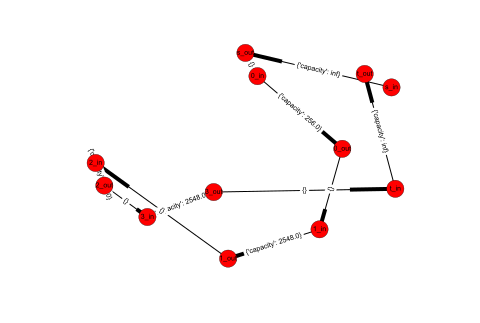

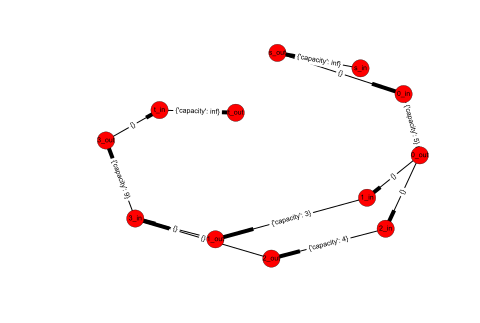

In [10]:
draw_graph(em.sfc_graph_reduced)
draw_graph(tm.sfc_graph_reduced)